In [1]:
import pandas as pd
import numpy as np

In [2]:
url = "https://raw.githubusercontent.com/ga-students/SF-DAT-20/master/Data/spambase.csv"
SpamData = pd.read_csv(url)
SpamData.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,is_spam
0,0.00,0.64,0.64,0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0,0.135,0.000,0.000,3.537,40,191,1


For the dictionary of this dataset please refer to https://archive.ics.uci.edu/ml/datasets/Spambase

In [3]:
ListOfAllVariables = SpamData.columns.values
X = SpamData[ListOfAllVariables]
del X['is_spam']
y = SpamData['is_spam']


In [4]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()
lm.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [5]:
from sklearn.cross_validation import cross_val_score
print "Accuracy:",cross_val_score(lm,X,y,cv=10).mean()
MisClassificationError = 1 - (cross_val_score(lm,X,y,cv=10).mean())
print "Misclassification Error:",MisClassificationError  #our misclassification Error is not bad at detecting spam as spam and ham as ham!

Accuracy: 0.918463836539
Misclassification Error: 0.082188337374


In [6]:
SpamData['is_spam'].describe()  #We love that misclassification error even more! 39% of e-mails were spam

count    4601.000000
mean        0.394045
std         0.488698
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: is_spam, dtype: float64

In [9]:
from sklearn.metrics import confusion_matrix
y_hat = lm.predict(X)
print pd.crosstab(y, y_hat, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted     0     1   All
True                       
0          2662   126  2788
1           186  1627  1813
All        2848  1753  4601


#### How much is our FPR, TPR, TNR, FNR? 

FPR: FP/N = 126/2788 = 4.5%

TPR: TP/P = 1627/1813 = 89.7%

TNR: TN/N = 2662/2788 = 95.5%

FNR: FN/P = 186/1813 = 10.3%



#### How much is our current intercept?

In [10]:
lm.intercept_

array([-1.44908453])

#### In our current setting 39% of our data was Spam. How would you adjust your model if you knew that in reality only 10% of e-mails are spam?

Answer: Raise the threshold for predicting that emails are spam to be higher, which would make less email classified as spam

In [11]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
y_hat_probability = lm.predict_proba(X).T[1]  #T[1] returns probability of belonging to class
print(y_hat_probability)
print(roc_auc_score(y, y_hat_probability))
vals = roc_curve(y, y_hat_probability)  #an excellent value!

[ 0.5963101   0.97267807  0.99997911 ...,  0.03591288  0.09639761
  0.04595066]
0.975490558781


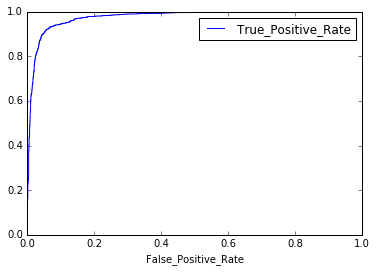

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
Roc_DataFrame = pd.DataFrame({'False_Positive_Rate':vals[0],'True_Positive_Rate':vals[1]})
Roc_DataFrame.plot(x = 'False_Positive_Rate' , y = 'True_Positive_Rate' ) #beautiful Graph


#### Now let's find out the most important variables

In [13]:
# let's first standardize our data
def Standardize(X):
    X_Max = X.max()
    X_Min = X.min()
    X_Standardized = (X-X_Min)/(X_Max - X_Min)
    return X_Standardized

NameOfVariables = X.columns.values
for i in NameOfVariables:
    SpamData[i] = Standardize(SpamData[i])
X = SpamData[ListOfAllVariables]
del X['is_spam']  

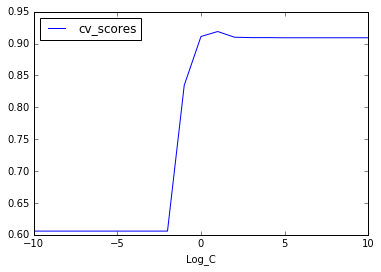

In [14]:
# Try testing and plotting 
c_list = np.logspace(-10,10,21) 
c_index = np.linspace(-10,10,21)
# C is just the inverse of Lambda - the smaller the C, the stronger the regulatization. 
# The smaller C's choose less variables
cv_scores = []
for c_score in c_list:
    lm = LogisticRegression(C = c_score,penalty = "l1") #Setting penalty to l1 specifies lasso regression, l2 is ridge
    cv_scores.append(cross_val_score(lm,X,y,cv=10).mean())


C_Choice_df = pd.DataFrame({'cv_scores': cv_scores ,'Log_C': c_index })
C_Choice_df.plot(x ='Log_C',y = 'cv_scores' )


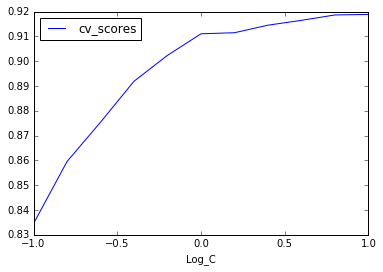

In [15]:
# Try testing and plotting subset of c values to hone in on best one
c_list = np.logspace(-1,1,11) 
c_index = np.linspace(-1,1,11)
# C is just the inverse of Lambda - the smaller the C, the stronger the regulatization. 
# The smaller C's choose less variables
cv_scores = []
for c_score in c_list:
    lm = LogisticRegression(C = c_score, penalty = "l1")
    cv_scores.append(cross_val_score(lm,X,y,cv=10).mean())


C_Choice_df = pd.DataFrame({'cv_scores': cv_scores ,'Log_C': c_index })
C_Choice_df.plot(x ='Log_C',y = 'cv_scores' )
# It looks like we should choose C = 0; C = 1 is actually better but we would like to keep the smallest C that is
# good in comparison to our best possible outcome. The SIMPLER THE BETTER! SMALLER C's GIVE YOU MORE RESTRICTIVE
# OUTPUTS - BETTER INTERPRETATION

In [18]:
lm = LogisticRegression(C = 10**(0), penalty = "l1")
lm.fit(X,y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [19]:
Var_coef = zip(NameOfVariables,lm.coef_[0])
print Var_coef

[('word_freq_make', -0.53554779375024253), ('word_freq_address', -1.1372617505223912), ('word_freq_all', 0.93262368804263696), ('word_freq_3d', 1.6383364009849155), ('word_freq_our', 4.9701540612186488), ('word_freq_over', 3.0882537341304825), ('word_freq_remove', 16.492800873151602), ('word_freq_internet', 5.1491268271320472), ('word_freq_order', 3.0688481815658859), ('word_freq_mail', 1.1095300439379292), ('word_freq_receive', 0.0), ('word_freq_will', -1.2380253147732996), ('word_freq_people', 0.0), ('word_freq_report', 0.014193966701056812), ('word_freq_addresses', 1.9353683412254041), ('word_freq_free', 16.157338591997171), ('word_freq_business', 6.0088335210608079), ('word_freq_email', 1.9066449673774437), ('word_freq_you', 1.4738621973333847), ('word_freq_credit', 4.9250392725297392), ('word_freq_your', 2.7348527155704017), ('word_freq_font', 4.3738291625637773), ('word_freq_000', 11.964133991553053), ('word_freq_money', 5.6930097618560893), ('word_freq_hp', -27.776994275673644),

It seems like char_freq_$ has the highest effect on an email be a spam, the next word that highly affects the probability of spam is remove, followed by  free, 000, b !, etc.

The most unlikely characters that are in spam emails are george, hp, edu, meeting, etc.. 

12 words  and characters - with coefficients 0 - have mixed effect on probability of spam and ham. 

#### Now let's look at ROC, AUC, confusion matrix of our optimal model

In [23]:
y_hat = lm.predict(X)
#confusion_matrix(y, y_hat)
print pd.crosstab(y, y_hat, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted     0     1   All
True                       
0          2666   122  2788
1           262  1551  1813
All        2928  1673  4601


[ 0.48492461  0.94171121  0.99798138 ...,  0.09795544  0.17409714
  0.10084735]
0.970620977462


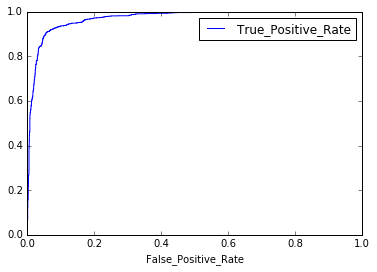

In [22]:
y_hat_probability = lm.predict_proba(X).T[1]  #T[1] returns probability of belonging to class
print(y_hat_probability)
print(roc_auc_score(y, y_hat_probability))
vals = roc_curve(y, y_hat_probability)
Roc_DataFrame = pd.DataFrame({'False_Positive_Rate':vals[0],'True_Positive_Rate':vals[1]})
Roc_DataFrame.plot(x = 'False_Positive_Rate' , y = 'True_Positive_Rate' ) #agian beautiful Graph

#### Now let's play with threshold

In [38]:
def PredictThreshold(Predictprob,Threshhold):
    y_predict = 0
    if (Predictprob >= Threshhold):
        y_predict = 1
    return y_predict

y_hat_probability = lm.predict_proba(X).T[1]
y_hat_predict_threshold = []
threshold = 0.8
for i in y_hat_probability:
    prediction_val = PredictThreshold(i,threshold)
    y_hat_predict_threshold.append(prediction_val)

#confusion_matrix(y, y_hat_predict_threshold)    
#please play with threshold and discuss your outputs. For example if it is really important
#for you to reduce FP, what should you do?

In [37]:
print pd.crosstab(y, np.array(y_hat_predict_threshold), rownames=['True'], colnames=['Predicted'], margins=True)


Predicted     0    1   All
True                      
0          2765   23  2788
1           858  955  1813
All        3623  978  4601
